# **Breast Cancer - Comparative Analysis (Explainability with GradCAM) - MobileNetV2**

Dataset (Train and Validation) link: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

Annotated Dataset (Test) link: https://figshare.com/articles/dataset/BreCaHAD_A_Dataset_for_Breast_Cancer_Histopathological_Annotation_and_Diagnosis/7379186?file=13646369

Note: The test set only contains malignant class images.

The following project will focus on finding the architecture (used with GradCAM) with the best explainability efficiency. The proposed architectures for this experiment are:
* EfficientNetB0
* VisionTrasformer
* DenseNet201
* NasNetLarge
* MobileNetV2

This notebook represents one of the five which will run experiments with images where the Visual Magnification factor is 400x - MobileNetV2.   

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json

import os
import random
from random import random, randint, seed
import pickle
import pathlib
import warnings
import platform

import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
print("Python- Versão: ", platform.python_version())
print("TensorFLow - Versão: ",tf.__version__)

# Checar GPUs
if not tf.test.gpu_device_name():
    warnings.warn('GPU não encontrada.')
else:
    print(f'Dispositivo GPU padrão: {tf.test.gpu_device_name()}')
    print("Número de GPUs Disponíveis: ", len(tf.config.list_physical_devices('GPU')))

Python- Versão:  3.9.13
TensorFLow - Versão:  2.11.0


C:\Users\IA\AppData\Local\Temp\ipykernel_19176\1723700887.py:6: UserWarning: GPU não encontrada.
  warnings.warn('GPU não encontrada.')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/1_ DESENVOLVIMENTO  AMPLIAR TEC 4.0/Datasets/Anel de Sinete/ml-dataset-sinet-ring.zip"

A saída de streaming foi truncada nas últimas 5000 linhas.
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47118_22363.png  
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47118_22363_0.png  
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47118_22363_2.png  
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47118_22363_3.png  
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47162_29092.png  
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47162_29092_0.png  
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47162_29092_2.png  
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47162_29092_3.png  
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47187_23110.png  
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47187_23110_0.png  
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47187_23110_2.png  
 extracting: ml-dataset-sinet-ring/train/com anel/patch_47187_23110_3.png  
 extracting: ml-dataset-sinet-ring/

In [ ]:
for dirpath, dirnames, filenames in os.walk('ml-dataset-sinet-ring'):
    if len(filenames)!=0:
        print(f'Existem {len(filenames)} imagens em  {dirpath}.')

Existem 3170 imagens em  ml-dataset-sinet-ring/train/sem anel.
Existem 4120 imagens em  ml-dataset-sinet-ring/train/com anel.
Existem 79 imagens em  ml-dataset-sinet-ring/val/sem anel.
Existem 79 imagens em  ml-dataset-sinet-ring/val/com anel.
Existem 80 imagens em  ml-dataset-sinet-ring/test/sem anel.
Existem 84 imagens em  ml-dataset-sinet-ring/test/com anel.


In [ ]:
train_dir = 'ml-dataset-sinet-ring/train'
val_dir = 'ml-dataset-sinet-ring/val'
test_dir = 'ml-dataset-sinet-ring/test'

# Especificações para o treinamento da rede
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 100

In [ ]:
train_datagen = ImageDataGenerator(rescale=None)
valid_datagen = ImageDataGenerator(rescale=None)
test_datagen = ImageDataGenerator(rescale=None)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

val_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

Found 7290 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [ ]:
class_names = list(val_data.class_indices.keys())
class_names

['com anel', 'sem anel']

In [ ]:
# Criar a arquitetura da camada densa do modelo para o Fine Tuning
inputs = Input(shape=IMG_SHAPE)

xi = tf.cast(inputs, tf.float32)
xi = tf.keras.applications.mobilenet_v2.preprocess_input(xi)

basemodel = MobileNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor = xi,
                        input_shape=IMG_SHAPE,
                        pooling='max')

x = BatchNormalization()(basemodel.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#model.summary()

## Fine Tuning - Fase 1 (warm up) -> treina apenas a camada densa

In [ ]:
# Congela as camadas do modelo base (as camadas de convolução não serão treinadas novamente)
for layer in basemodel.layers:
    layer.trainable = False  

In [ ]:
base_learning_rate = 0.0001
opt = Adam(learning_rate=base_learning_rate)
# binary -> binary_crossentropy; categorical -> categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
    # Early Stopping do trinamento
    early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt = keras.callbacks.ModelCheckpoint(
    filepath='callbacks/melhor_modelo_MobileNetV2_ft.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks = [early_stop, model_ckpt]

In [ ]:
# Fase 1 - treina apenas com algumas épocas (40% do total)
initial_epochs = int(EPOCHS*0.4)
history = model.fit(train_data,
                    epochs=initial_epochs,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks)

Epoch 1/40
228/228 [==============================] - 45s 156ms/step - loss: 0.4368 - accuracy: 0.7975 - val_loss: 0.2617 - val_accuracy: 0.8987
Epoch 2/40
228/228 [==============================] - 35s 154ms/step - loss: 0.2669 - accuracy: 0.8864 - val_loss: 0.2056 - val_accuracy: 0.9114
Epoch 3/40
228/228 [==============================] - 33s 146ms/step - loss: 0.2242 - accuracy: 0.9073 - val_loss: 0.1836 - val_accuracy: 0.9177
Epoch 4/40
228/228 [==============================] - 34s 151ms/step - loss: 0.1887 - accuracy: 0.9211 - val_loss: 0.1745 - val_accuracy: 0.9304
Epoch 5/40
228/228 [==============================] - 35s 155ms/step - loss: 0.1620 - accuracy: 0.9344 - val_loss: 0.1661 - val_accuracy: 0.9241
Epoch 6/40
228/228 [==============================] - 33s 146ms/step - loss: 0.1461 - accuracy: 0.9417 - val_loss: 0.1709 - val_accuracy: 0.9114
Epoch 7/40
228/228 [==============================] - 35s 155ms/step - loss: 0.1332 - accuracy: 0.9471 - val_loss: 0.1844 - val_ac

## Fine Tuning - Fase 2 -> treina todo o modelo do fine tuning - descongela as camadas de convolução

In [ ]:
print("Número de camadas do modelo base: ", len(basemodel.layers))

Número de camadas do modelo base:  158


In [ ]:
# Descongelar as 30% camadas finais e que não seja do tipo BatchNormalization do modelo base
# Note que vpcê pode adicionar mais camadas se o modelo não for muito grande
count = 0
for layer in basemodel.layers[-int(len(basemodel.layers)*0.3):]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [ ]:
# É necessário diminuir a base_learning_rate para que o modelo não tenha convergência muito rápida
# pois se trata d eum modelo grande
opt = Adam(learning_rate=base_learning_rate/10)
# binary -> binary_crossentropy; categorical -> categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
# EarlyStopping do trinamento
early_stop2 = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt2 = keras.callbacks.ModelCheckpoint(
    filepath='callbacks/melhor_modelo_MobileNetV2_ft.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks2 = [early_stop2, model_ckpt2]

In [ ]:
# Fase 2 - treina apenas com a quantidade de épocas que faltam (60% finais)
# Note que iniciará de initial_epoch=history.epoch[-1]
history_fine = model.fit(train_data,
                    epochs=EPOCHS,
                    initial_epoch=history.epoch[-1],
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks2)

Epoch 12/100
228/228 [==============================] - 46s 186ms/step - loss: 0.0877 - accuracy: 0.9665 - val_loss: 0.1634 - val_accuracy: 0.9367
Epoch 13/100
228/228 [==============================] - 36s 157ms/step - loss: 0.0787 - accuracy: 0.9711 - val_loss: 0.1683 - val_accuracy: 0.9430
Epoch 14/100
228/228 [==============================] - 36s 156ms/step - loss: 0.0653 - accuracy: 0.9759 - val_loss: 0.1064 - val_accuracy: 0.9557
Epoch 15/100
228/228 [==============================] - 36s 159ms/step - loss: 0.0486 - accuracy: 0.9846 - val_loss: 0.1000 - val_accuracy: 0.9620
Epoch 16/100
228/228 [==============================] - 35s 153ms/step - loss: 0.0443 - accuracy: 0.9846 - val_loss: 0.1135 - val_accuracy: 0.9557
Epoch 17/100
228/228 [==============================] - 37s 160ms/step - loss: 0.0433 - accuracy: 0.9852 - val_loss: 0.1052 - val_accuracy: 0.9557
Epoch 18/100
228/228 [==============================] - 36s 157ms/step - loss: 0.0350 - accuracy: 0.9888 - val_loss: 0

In [ ]:
# Avaliação usando os dados de testes
loss, acc = model.evaluate(test_data)
print ("Test accuracy: %.3f" % acc)
print ("Test loss: %.3f" % loss)

6/6 [==============================] - 8s 138ms/step - loss: 0.1925 - accuracy: 0.9146
Test accuracy: 0.915
Test loss: 0.193


In [ ]:
model.save("sinete_model_2.h5")

# GRADCAM

In [12]:
#test_dir = 'SiDi_BreCaHAD_test/dataset'
data_dir_test = pathlib.Path(test_dir)

class_names = np.array(sorted([item.name for item in data_dir_test.glob('*')]))
print(f'Types: {class_names}')

Types: ['com anel' 'sem anel']


In [ ]:
# Carrega o modelo
model = load_model("/content/sinete_model_2.h5")

In [13]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, keras.layers.Conv2D), model.layers))[-1].name
print(last_conv_layer_name) 

Conv_1


In [14]:
def get_img_array(img_path, size):

    img = tf.keras.utils.load_img(img_path, target_size=size)
    
    array = tf.keras.utils.img_to_array(img)
    
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs],[model.get_layer(last_conv_layer_name).output, model.output])
           
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        predictions = tf.squeeze(predictions)
        if pred_index is None:
            pred_index = tf.argmax(predictions)
        class_channel = predictions[pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [37]:
# Prepare image
def generate_heatmap(img_path):
    img_array = get_img_array(img_path, size=(224,224))
    print(f"type: {type(img_array)}, shape: {img_array.shape}")

    preds = model.predict(img_array)
    print(preds)
    top_pred_index = tf.argmax(preds[0])

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heat_test = heatmap.copy()

    return heatmap, class_names[top_pred_index], preds[0][top_pred_index]

In [39]:
def save_and_display_gradcam(img_path, heatmap, alpha=1, pred=None):

    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    if pred == 'com anel':
        jet = cm.get_cmap("jet")
    else:
        jet = cm.get_cmap("Blues")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
     

    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap)


    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)


    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_BGR2GRAY)

    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return thresh

## Gerar dataset

In [ ]:
def loading_json(filen='SiDi_BreCaHAD_test/groundTruth/'):
    tumor_cells = {}
    annot_points = {}
    
    for root, dirs, items in os.walk(filen):
        for i, item in enumerate(items):

            f = open(filen+item)
            data = json.load(f)
            
            tumor_cells[item.split('.')[0]] = len(data['tumor'])
            
            x_y = []
            for j, points in enumerate(data['tumor']):
                values_i_j = []
                
                values_i_j.append(int(points['x']*1360))
                values_i_j.append(int(points['y']*1024))

                x_y.append(values_i_j)

            annot_points[item.split('.')[0]] = x_y

            f.close()
            
    return tumor_cells, annot_points

In [ ]:
def getting_probs(filen='SiDi_BreCaHAD_test/dataset/malignant/'):
    probs = []
    classes = []
    masks = []
    for root, dirs, items in os.walk(filen):
        for item in items:
            heatmap, class_, prob = generate_heatmap(filen+item)
            mask = save_and_display_gradcam(filen+item, heatmap, pred=class_)
            probs.append(round(prob*100,2))
            classes.append(class_)
            masks.append(mask)
            

    return classes, masks, probs

In [ ]:
def checking_points(annot_points, lst_heatmaps):

    correct_values = []
    i = 0
    
    for k, v in annot_points.items():
        got_it_right = 0
        mask_matrix = lst_heatmaps[i]
        
        for a, b in enumerate(v):
            if mask_matrix[b[1]][b[0]] > 0:
                got_it_right += 1    
        correct_values.append(got_it_right)
        i += 1
        
    return correct_values

In [ ]:
def generating_dataset():
    
    tumor_cells, annot_points = loading_json()
    lst_classes, lst_heatmaps, lst_probs = getting_probs()
    
    lst_tumors = checking_points(annot_points, lst_heatmaps)
    tumor_region = []
    accuracy = []

    tumor_cells_values = list(tumor_cells.values())
    
    for i, qtd in enumerate(lst_tumors):
        if lst_classes[i] == 'benign':
            tumor_region.append(0)
            accuracy.append(0)
            
        else:
            tumor_region.append(round((qtd/tumor_cells_values[i])*100, 2))
            
    
    dataframe = pd.DataFrame(data=[tumor_cells.keys(), tumor_cells.values(), lst_classes, lst_probs,
                                  lst_tumors, tumor_region],
                             index=['Case', 'Total Tumor Cells', 'Pred. Type', 'Probability (%)',
                                     'Tumors Found' ,'Interpret. Region Accuracy (%)']).transpose()
    
    return dataframe

In [ ]:
df = generating_dataset()

In [ ]:
accuracy = 100*(len(df[(df['Pred. Type'] == 'malignant')].index)/len(df.index))
print("Acurácia de Classificação (%): ",round(accuracy,1))

Acurácia de Classificação (%):  98.7


In [ ]:
# Interpretability

mean = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total = df[df['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind = df[df['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model = round(mean, 2)
std_deviation = round(stdd, 2)
median_model = round(median, 2)

print(f'Model Average Interpretability: {itp_model} +/- {std_deviation}. With Median: {median_model}')
print(f'\nMin.: {min_v} | Max.: {max_v}')

Model Average Interpretability: 41.52 +/- 17.77. With Median: 40.91

Min.: 1.77 | Max.: 100.0


(array([ 8., 12., 20., 40., 32., 28.,  9.,  4.,  2.,  2.]),
 array([1.77, 11.593, 21.416, 31.239, 41.062000000000005,
        50.885000000000005, 60.708000000000006, 70.53099999999999, 80.354,
        90.177, 100.0], dtype=object),
 <BarContainer object of 10 artists>)

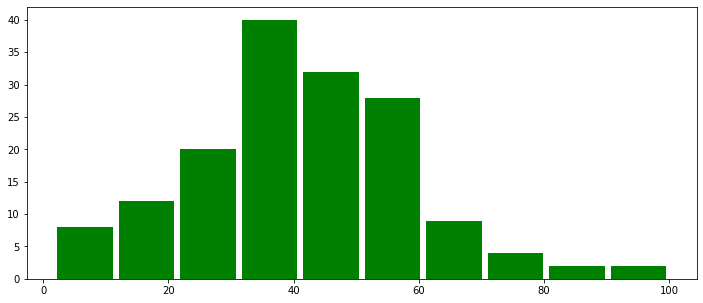

In [ ]:
plt.figure(figsize=(12,5))
values = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values, bins=10, color='Green', rwidth=0.9)

## TESTE

In [40]:
def display_gradcam(img_path, heatmap, alpha=1, pred=None):

    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    if pred == 'com anel':
        jet = cm.get_cmap("jet")
    else:
        jet = cm.get_cmap("Blues")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
     
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap)

    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    plt.imshow(superimposed_img)

    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_BGR2GRAY)

    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return thresh

In [ ]:
case='73311_29614' # 'Case_7-03'

In [35]:
#IMG = 'ml-dataset-sinet-ring/test/sem anel/patch_'+case+'.png'
IMG = '/content/patch_434.png'
#PATH1 = 'SiDi_BreCaHAD_test/groundTruth_display/'+case+'.png'

type: <class 'numpy.ndarray'>, shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 21ms/step
[[0.9985044  0.00149562]]


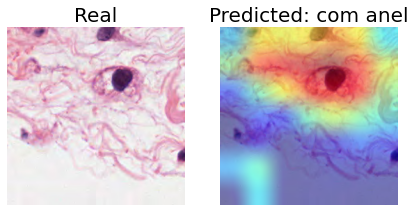

In [41]:

#img = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG)
heatmap1, class_1, probs1 = generate_heatmap(IMG)

plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.title('Real',fontsize=20)
plt.axis(False)
plt.imshow(img_orig)
plt.subplot(1,2,2)
plt.title(f'Predicted: {class_1}', fontsize=20)
plt.axis(False)
result=display_gradcam(img_path=IMG, heatmap=heatmap1, pred=class_1)
# plt.subplot(1,3,3)
# plt.title('Annotated', fontsize=20)
# plt.axis(False)
# plt.imshow(img)

In [ ]:
print(result[600][600])

print(result[1000][600])

print(result[800][1200])

255
0
0


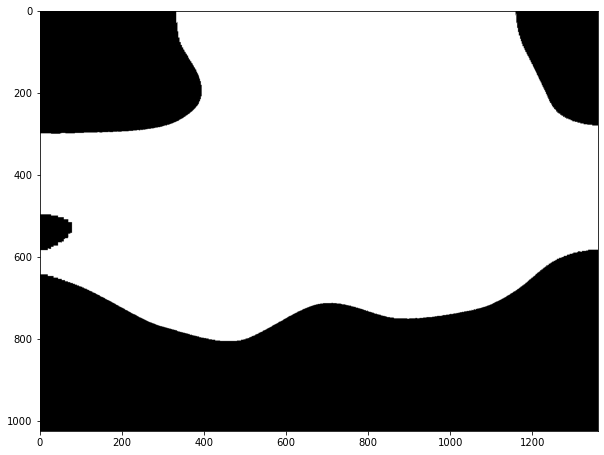

In [ ]:
plt.figure(figsize=(10,10))

plt.imshow(result, cmap='gray')

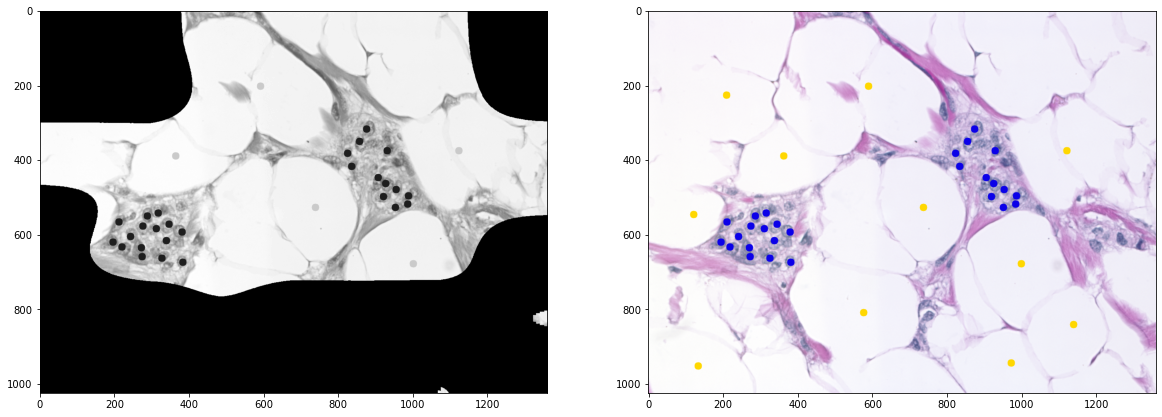

In [ ]:
# inverting result mask
plt.figure(figsize=(20,20))
data1 = cv.imread(PATH1)
data1 = cv.cvtColor(data1, cv.COLOR_BGR2RGB)
final = cv.bitwise_and(data1, data1, mask = result)
final = cv.cvtColor(final, cv.COLOR_RGB2GRAY)
plt.subplot(1,2,1)
plt.imshow(final, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(data1)

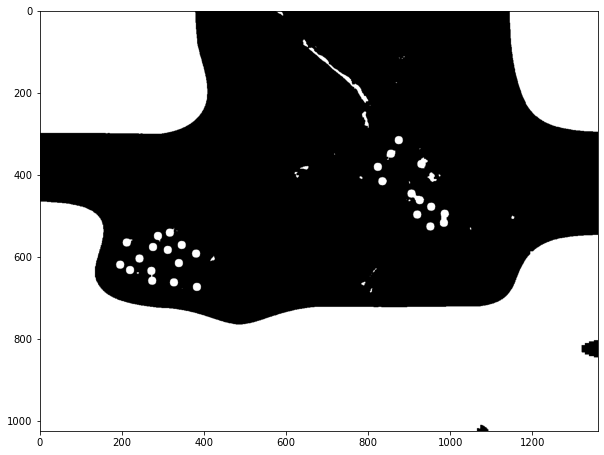

In [ ]:
plt.figure(figsize=(10,10))

kernel = np.ones((5,5),np.uint8)
mask2 = cv.threshold(final,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
mask2 = cv.morphologyEx(mask2, cv.MORPH_CLOSE, kernel)
mask2 = np.uint8(mask2)
plt.imshow(mask2, cmap='gray')

In [ ]:
plt.figure(figsize=(10,10))

data2 = data1.copy()

##########
p_edges = cv.Canny(mask2, 0, 255)

##########
rows = p_edges.shape[0]
circles = cv.HoughCircles(mask2, cv.HOUGH_GRADIENT, dp=1.1, minDist=1, param1=100, param2=15, minRadius=2, maxRadius=11)
print(circles.shape)

if circles is not None:
    # mudando o tipo de dado para int
    circles = np.uint16(np.around(circles))
    for circ in circles[0, :]:
        center = (circ[0], circ[1])

        # centro do círculo
        cv.circle(data2, center, 1, (0, 100, 100), 3)

        # círculo externo
        radius = circ[2]
        cv.circle(data2, center, radius, (0, 255, 0), 4)

plt.imshow(data2)